In [1]:
import sys, os
from omegaconf import OmegaConf
import torch
import numpy as np
import pandas as pd

sys.path.append("/home/jgershon/git/cleo/reinforced_mpnn")
from policy_utils import PolicyMPNN, alphabet


test_pdb = "/home/jgershon/projects/itopt/declan/TS1_trp_6_conformers_0008_000_10-atomized-bb-False_4_9_MPNN.pdb"

config = {
    "run_name": "test_v1",
    "output_dir": "/home/jgershon/projects/itopt/policy_mpnn/testing",
    "model_type": "ligand_mpnn",
    "N_steps": 500,
    "pdb": test_pdb,
    "batch_size": 16,
    "temperature": 1.0,
    "omit_AA": "CX",
    "lr": 1e-4,
    "fixed_residues": "A29 A30 A31 A32 A60 A61 A62 A63 A100 A101 A102 A103",
    "checkpoint_every_n_steps": 10,
    "reward": {
        "_target_": "reward_utils.EnrichAminoAcidReward",
        "AA_to_enrich": "E"
    },
    "eval":False,
    "checkpoint_path": None,
}

config = OmegaConf.create(config)

policy_mpnn = PolicyMPNN(config)


/home/jgershon/git/cleo/reinforced_mpnn/policy_utils.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=self.device)


In [6]:
feature_dict = policy_mpnn.featurize_pdb(config.pdb)
h_V, h_E, E_idx = policy_mpnn.encode_initial_state(feature_dict)

# turn on grads for state features
h_V.requires_grad = True
h_E.requires_grad = True



In [7]:
# decode
B_decoder = feature_dict["batch_size"]
S_true = feature_dict["S"] #[B,L] - integer proitein sequence encoded using "restype_STRtoINT
#R_idx = feature_dict["R_idx"] #[B,L] - primary sequence residue index
mask = feature_dict["mask"] #[B,L] - mask for missing regions - should be removed! all ones most of the time
chain_mask = feature_dict["chain_mask"] #[B,L] - mask for which residues need to be fixed; 0.0 - fixed; 1.0 - will be designed
bias = feature_dict["bias"] #[B,L,21] - amino acid bias per position

#chain_labels = feature_dict["chain_labels"] #[B,L] - integer labels for chain letters
randn = feature_dict["randn"] #[B,L] - random numbers for decoding order; only the first entry is used since decoding within a batch needs to match for symmetry
temperature = feature_dict["temperature"] #float - sampling temperature; prob = softmax(logits/temperature)
B, L = S_true.shape

decoding_order = torch.argsort((chain_mask+0.0001)*(torch.abs(randn))) #[numbers will be smaller for places where chain_M = 0.0 and higher for places where chain_M = 1.0]

E_idx = E_idx.repeat(B_decoder, 1, 1)
permutation_matrix_reverse = torch.nn.functional.one_hot(decoding_order, num_classes=L).float()
order_mask_backward = torch.einsum('ij, biq, bjp->bqp',(1-torch.triu(torch.ones(L,L, device=policy_mpnn.device))), permutation_matrix_reverse, permutation_matrix_reverse)
mask_attend = torch.gather(order_mask_backward, 2, E_idx).unsqueeze(-1)
mask_1D = mask.view([B, L, 1, 1])
mask_bw = mask_1D * mask_attend
mask_fw = mask_1D * (1. - mask_attend)

#repeat for decoding
S_true = S_true.repeat(B_decoder, 1)
h_V = h_V.repeat(B_decoder, 1, 1)
h_E = h_E.repeat(B_decoder, 1, 1, 1)
chain_mask = chain_mask.repeat(B_decoder, 1)
mask = mask.repeat(B_decoder, 1)
bias = bias.repeat(B_decoder, 1, 1)

#-----

all_probs = torch.zeros((B_decoder, L, 20), device=policy_mpnn.device, dtype=torch.float32)
all_log_probs = torch.zeros((B_decoder, L, 21), device=policy_mpnn.device, dtype=torch.float32)
h_S = torch.zeros_like(h_V, device=policy_mpnn.device)
S = 20*torch.ones((B_decoder, L), dtype=torch.int64, device=policy_mpnn.device)
h_V_stack = [h_V] + [torch.zeros_like(h_V, device=policy_mpnn.device) for _ in range(len(policy_mpnn.model.decoder_layers))]

h_EX_encoder = policy_mpnn.cat_neighbors_nodes(torch.zeros_like(h_S), h_E, E_idx)
h_EXV_encoder = policy_mpnn.cat_neighbors_nodes(h_V, h_EX_encoder, E_idx)
h_EXV_encoder_fw = mask_fw * h_EXV_encoder


for t_ in range(L):

    t = decoding_order[:,t_] #[B]
    chain_mask_t = torch.gather(chain_mask, 1, t[:,None])[:,0] #[B]
    mask_t = torch.gather(mask, 1, t[:,None])[:,0] #[B]
    bias_t = torch.gather(bias, 1, t[:,None,None].repeat(1,1,21))[:,0,:] #[B,21]


    E_idx_t = torch.gather(E_idx, 1, t[:,None,None].repeat(1,1,E_idx.shape[-1]))
    h_E_t = torch.gather(h_E, 1, t[:,None,None,None].repeat(1,1,h_E.shape[-2], h_E.shape[-1]))
    h_ES_t = policy_mpnn.cat_neighbors_nodes(h_S, h_E_t, E_idx_t)
    h_EXV_encoder_t = torch.gather(h_EXV_encoder_fw, 1, t[:,None,None,None].repeat(1,1,h_EXV_encoder_fw.shape[-2], h_EXV_encoder_fw.shape[-1]))

    mask_bw_t = torch.gather(mask_bw, 1, t[:,None,None,None].repeat(1,1,mask_bw.shape[-2], mask_bw.shape[-1]))

    for l, layer in enumerate(policy_mpnn.model.decoder_layers):
        h_ESV_decoder_t = policy_mpnn.cat_neighbors_nodes(h_V_stack[l], h_ES_t, E_idx_t)
        h_V_t = torch.gather(h_V_stack[l], 1, t[:,None,None].repeat(1,1,h_V_stack[l].shape[-1]))
        h_ESV_t = mask_bw_t * h_ESV_decoder_t + h_EXV_encoder_t
    

        # JG: replaced mask_V with None, could be mask_t
        # This line is causing issues with backprop because was an in-place operation
        h_V_stack[l+1] = h_V_stack[l+1].scatter(1, t[:,None,None].repeat(1,1,h_V.shape[-1]), layer(h_V_t, h_ESV_t, mask_V=None))


    h_V_t = torch.gather(h_V_stack[-1], 1, t[:,None,None].repeat(1,1,h_V_stack[-1].shape[-1]))[:,0]
    logits = policy_mpnn.model.W_out(h_V_t) #[B,21]
    log_probs = torch.nn.functional.log_softmax(logits, dim=-1) #[B,21]


    # JG need to add code here to pick out specific samples
    probs = torch.nn.functional.softmax((logits.detach()+bias_t) / temperature, dim=-1) #[B,21]

    probs_sample = probs[:,:20]/torch.sum(probs[:,:20], dim=-1, keepdim=True) #hard omit X #[B,20]
    S_t = torch.multinomial(probs_sample, 1)[:,0] #[B]

    all_probs.scatter_(1, t[:,None,None].repeat(1,1,20), (chain_mask_t[:,None,None]*probs_sample[:,None,:]).float())
    all_log_probs.scatter_(1, t[:,None,None].repeat(1,1,21), (chain_mask_t[:,None,None]*log_probs[:,None,:]).float())

    with torch.no_grad():
        S_true_t = torch.gather(S_true, 1, t[:,None])[:,0]
        S_t = (S_t*chain_mask_t+S_true_t*(1.0-chain_mask_t)).long()
        h_S.scatter_(1, t[:,None,None].repeat(1,1,h_S.shape[-1]), policy_mpnn.model.W_s(S_t)[:,None,:])
        S.scatter_(1, t[:,None], S_t[:,None])

    break

output_dict = {"S": S, "sampling_probs": all_probs, "log_probs": all_log_probs, "decoding_order": decoding_order}


In [8]:
h_V_t.shape

torch.Size([16, 128])

In [17]:
t

tensor([ 62,  60,  28,  28,  31,  28,  62,  30, 101,  30, 100,  60,  60, 101,
         60, 102])

In [20]:
B = S_true.shape[0]
S_true[torch.arange(B), t]

tensor([ 9, 12, 16, 16, 16, 16,  9,  0,  2,  0,  5, 12, 12,  2, 12,  8],
       dtype=torch.int32)

In [1]:
h_V_stack[-1]

NameError: name 'h_V_stack' is not defined

In [7]:
path = "/home/ssalike/Projects/itopt/policy_mpnn/opt_1/test_af3_winAS_train_metrics.csv"
df = pd.read_csv(path)

from matplotlib import pyplot as plt
import seaborn as sns

<Axes: xlabel='step', ylabel='acyl_rmsd_full_motif_best_mean'>

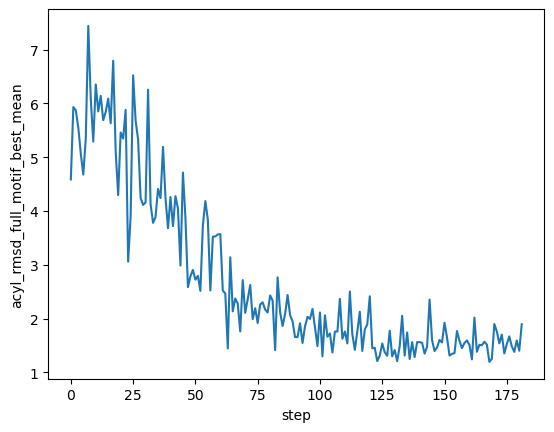

In [8]:
sns.lineplot(data=df, x="step", y="acyl_rmsd_full_motif_best_mean")

In [9]:
df[-20:]

,step,runtime,acyl_rmsd_full_motif_best_mean,loss,reward
162,162,20165.5143,2.0169,12.4046,0.8064
163,163,20315.0074,1.3817,24.0913,0.8705
164,164,20464.0302,1.5122,21.2565,0.8574
165,165,20613.3118,1.5036,22.5221,0.8582
166,166,20762.6875,1.5693,19.7875,0.8516
167,167,20912.6537,1.5155,21.0690,0.8570
168,168,21062.0636,1.1938,26.7374,0.8895
169,169,21210.9199,1.2522,26.0600,0.8836
170,170,21359.6751,1.8985,13.9850,0.8183
171,171,21511.0318,1.7608,16.3427,0.8322


<Axes: xlabel='step', ylabel='reward'>

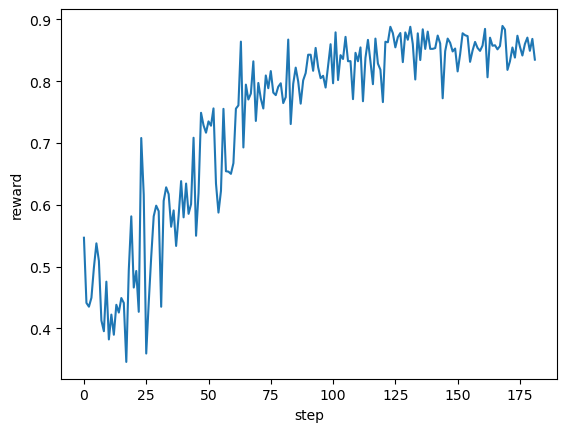

In [11]:
sns.lineplot(data=df, x="step", y="reward")

In [6]:
ls /home/ssalike/Projects/itopt/policy_mpnn/opt_1

af3_outputs/            test_af3_winAS_last.pt
test_af3_winAS_best.pt  test_af3_winAS_train_metrics.csv
